In [ ]:
from helchirss.domain import load_domain_string, Domain
domain_parser = Domain("mvcl/base.grammar")

meta_domain_str = ""
with open(f"domains/demo_domain.txt","r") as domain:
    for line in domain: meta_domain_str += line
domain = load_domain_string(meta_domain_str, domain_parser)

#domain.print_summary()

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


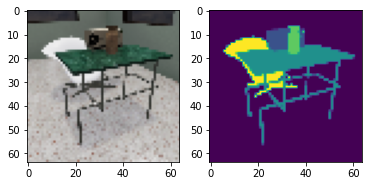

In [ ]:
import matplotlib.pyplot as plt
from mvcl.primitives import *
from helchriss.knowledge.executor import CentralExecutor
from mvcl.model import MetaVisualLearner
from mvcl.config import config
from datasets.tdw_dataset import TDWRoomDataset
from mvcl.percept.metanet import weighted_softmax
local = not torch.cuda.is_available()
syq_path = "/Users/melkor/Documents/datasets"
wys_path = "/data3/guofang/Meta/Benchmark/MultiPaperQA/wys_try/datasets"
dataset_dir = syq_path if local else wys_path

resolution = (64,64)
W, H = resolution
config.resolution = resolution
B, N, K = 1, W * H, 5
M = 5

dataset = TDWRoomDataset(resolution = resolution, root_dir = dataset_dir, split = "test")
loader = torch.utils.data.DataLoader(dataset, batch_size = B, shuffle = True)
for sample in loader:break;
"""load the dataset and make the ideal images and masks"""

ims = sample["img"]
target_masks = sample["masks"]
plt.subplot(121)
plt.imshow(ims[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(target_masks[0])
plt.show()

In [3]:
from tqdm import tqdm
from mvcl.primitives import *
model = MetaVisualLearner(domain, config)
#model.add_affinities(["albedo"])
model.add_affinities(["spelke"])
model.load_state_dict(torch.load("checkpoints/concept_expr_prox128.ckpt", map_location="cpu"))
model.grouper.competition.M = M

programs = [["(exists (green  (object $0) ))"],
            ["(exists (square $0))"],
            ["(exists (red (object $0)))"],
            ["(red (object $0))"],
            ["(green (object $0))"]]
#programs = [[" (green $0)"], [" (square $0)"], ["(exists (green $0))"]]
answers = [["yes"],["yes"], ["yes"], ["namo"], ["namo"]]


executor = model.central_executor
"""
x["executor"].entailment(x["features"],
            x["executor"].get_concept_embedding(name))
"""
for predicate in executor.predicates[1]:refractor(executor, predicate.name)
executor.redefine_predicate("object",
                            lambda x: {**x}
                            )


percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"]
indices = percept_outputs["indices"]
predict_masks, _ ,alive, prop_maps = model.extract_segments(obj_affinity, indices)
predict_masks = torch.einsum("bwhn,bnd->bwhn", predict_masks, alive)

alive = torch.ones_like(alive)
rand_features = torch.randn([B, M, 100])
rand_features.requires_grad_ = True

query_outputs = model.language_grounding(
    percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
print(query_outputs)

optim = torch.optim.Adam(executor.parameters(), lr = 2e-3)
for epoch in tqdm(range(1000)):
    query_outputs = model.language_grounding(
        percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
    loss = query_outputs["loss"]
    optim.zero_grad()
    loss.backward()
    optim.step()

query_outputs = model.language_grounding(
    percept_outputs, programs, answers,masks = predict_masks, alive = alive, features = rand_features)
print(query_outputs)

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


{'loss': tensor(0.5917, grad_fn=<DivBackward0>), 'answers': [['no', 'no', 'no', tensor([-2.4202, -1.2177, -0.6498, -1.3825, -1.6760],
       grad_fn=<MinimumBackward0>), tensor([-1.4095, -0.3596, -1.1077, -1.8338, -0.7686],
       grad_fn=<MinimumBackward0>)]]}


100%|██████████| 1000/1000 [00:03<00:00, 272.73it/s]

{'loss': tensor(0.0043, grad_fn=<DivBackward0>), 'answers': [['yes', 'yes', 'yes', tensor([-2.5895, -5.4110,  4.7512, -1.1384, -0.8953],
       grad_fn=<MinimumBackward0>), tensor([-0.0348,  4.7852, -5.5355, -1.6089, -0.4238],
       grad_fn=<MinimumBackward0>)]]}


In [5]:
"""indices in the shape of 3xBxNxK"""
indices = percept_outputs["indices"]

component_affinity = percept_outputs["affinity"]
"""affinity it self is in the form of BxNxK"""
B, N, K = component_affinity.shape

eps = 1e-6

mask1 = (torch.randn([B, N]) > 1.0).float()
mask2 = (torch.randn([B, N]) > 1.0).float()

def xor_implication(indices, affinity, mask):
    _, B, N, K = indices.shape

    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    u_mask = torch.gather(mask, dim = 1, index = filter_u)
    v_mask = torch.gather(mask, dim = 1, index = filter_v)
    aff = affinity.reshape(B, N * K).sigmoid()
    """uniform implication tensor"""
    uniform_mask = torch.min(u_mask , v_mask)
    uniform_implicate_tensor = uniform_mask * aff + (1 - uniform_mask) * 1.
    
    """xor implication tensor"""
    xor_mask = (u_mask * (1 - v_mask) ) + ((1 - u_mask) * v_mask)
    #aff = weighted_softmax(aff, xor_mask).sigmoid()
    xor_implicate_tensor = xor_mask * (1 - aff) + (1 - xor_mask) * 1.
    
    #print(uniform_implicate_tensor.shape, uniform_implicate_tensor.max(), uniform_implicate_tensor.min())
    #print(xor_implicate_tensor.max(), xor_implicate_tensor.min())
    """calculate the implication logits and xor logits"""
    uniform_implicate_log = torch.log(uniform_implicate_tensor)
    xor_implicate_log = torch.log(xor_implicate_tensor.clamp(eps, 1- eps))

    #print(xor_implicate_log.max(), xor_implicate_log.min())
    #xor_implicate_logits = logit(xor_implicate_tensor)
    #print(xor_implicate_log.max(), xor_implicate_log.min())

    #forall_quantized = torch.min(xor_implicate_logits, dim = -1).values
    forall_quantized =  torch.sum(xor_implicate_log) + torch.sum(uniform_implicate_log)
    
    return forall_quantized

def uniform_implication(indices, affinity, mask):
    """
    all inputs are logits: implication statement: forall i,j \in mask, affinity i,j = 1
    """
    _, B, N, K = indices.shape

    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    u_mask = torch.gather(mask, dim = 1, index = filter_u)
    v_mask = torch.gather(mask, dim = 1, index = filter_v)
    edge_mask = torch.min(u_mask , v_mask)

    
    aff = affinity.reshape(B, N * K).sigmoid()
    #aff = weighted_softmax(aff, edge_mask).sigmoid()

    implicate_tensor = edge_mask * aff + (1 - edge_mask) * 1

    
    #implicate_logits = logit(implicate_tensor)
    #forall_quantized = torch.min(implicate_logits, dim = -1).values
    
    implicate_log = torch.log(implicate_tensor.clamp(eps, 1- eps))
    forall_quantized = torch.sum(implicate_log)
    return forall_quantized


def pair_implication(indices, affinity, mask1, mask2):
    _, B, N, K = indices.shape

    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    u_mask = torch.gather(mask1, dim = 1, index = filter_u)
    v_mask = torch.gather(mask2, dim = 1, index = filter_v)

    edge_mask = u_mask * v_mask
    aff = affinity.reshape(B, N * K).sigmoid()

    implicate_tensor = edge_mask * aff + (1 - edge_mask) * 1
    
    implicate_log = torch.log(implicate_tensor.clamp(eps, 1- eps))
    forall_quantized = torch.sum(implicate_log)
    return forall_quantized

def pair_not_implication(indices, affinity, mask1, mask2):
    _, B, N, K = indices.shape

    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    u_mask = torch.gather(mask1, dim = 1, index = filter_u)
    v_mask = torch.gather(mask2, dim = 1, index = filter_v)

    edge_mask = u_mask * v_mask
    aff = affinity.reshape(B, N * K).sigmoid()

    implicate_tensor = edge_mask * (1-aff) + (1 - edge_mask) * 1
    
    implicate_log = torch.log(implicate_tensor.clamp(eps, 1- eps))
    forall_quantized = torch.sum(implicate_log)
    return forall_quantized

o1 = xor_implication(indices, component_affinity, mask1)
print(o1)

u1 = uniform_implication(indices, component_affinity, mask1)
print(u1)
p1 = pair_implication(indices, component_affinity, mask1, mask2)
print(p1)

tensor(-75244.1406, grad_fn=<AddBackward0>)
tensor(-11783.6807, grad_fn=<SumBackward0>)
tensor(-12511.1523, grad_fn=<SumBackward0>)


tensor(4.)


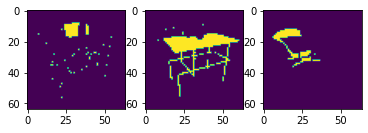

In [6]:
"""test the transfer utility"""
print(sample["masks"].max())

mask1 = (sample["masks"].int() == 1).float()
mask2 = (sample["masks"].int() == 2).float()
mask3 = (sample["masks"].int() == 4).float()
plt.subplot(131)
plt.imshow(mask1[0])
plt.subplot(132)
plt.imshow(mask2[0])
plt.subplot(133)
plt.imshow(mask3[0])
plt.show()

In [7]:
percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"].clamp(-20,10.)
indices = percept_outputs["indices"]

print(obj_affinity.max())
print(obj_affinity.min())

model.grouper.competition.M = 30
model.grouper.num_long_range = 232
predict_masks, _ ,alive, prop_maps = model.extract_segments(obj_affinity, indices)
predict_masks = torch.einsum("bwhn,bnd->bwhn", predict_masks, alive)

tensor(8.9637, grad_fn=<MaxBackward1>)
tensor(-17.8556, grad_fn=<MinBackward1>)


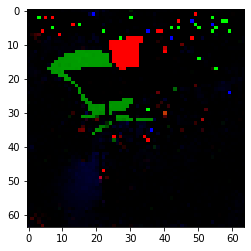

In [8]:
plt.figure("kalescope")
for i,prop_map in enumerate(prop_maps):
        map = prop_map.reshape([W, H, -1])
        plt.imshow(map.detach()[...,-3:])
        #plt.text(0,0,i)
        #plt.pause(0.00001)
        #plt.cla()


In [12]:
import sys
mask1 = mask1.reshape([B, N])
mask2 = mask2.reshape([B, N])
mask3 = mask3.reshape([B, N])


model.grouper.num_long_range = 32
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
epochs = 20
for epoch in range(epochs):
    percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
    obj_affinity = percept_outputs["affinity"]
    indices = percept_outputs["indices"]

    #p1 = pair_implication(indices, obj_affinity, mask1, mask2)
    p1 = xor_implication(indices, obj_affinity, mask1)
    p2 = xor_implication(indices, obj_affinity, mask2)
    p3 = xor_implication(indices, obj_affinity, mask3)
    #p1 = pair_implication(indices, obj_affinity, mask1, mask2)
    #p2 = pair_implication(indices, obj_affinity, mask1, mask3)

    #loss = -1 * p1
    if True:
        loss = 0
        loss += -1 * p1
        loss += -1 * p2
        loss += -1 * p3
    else:
        loss = -1 * torch.log(p1.sigmoid())
        loss += -1 * torch.log(p2.sigmoid())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if epoch % 1 == 0:
        sys.stdout.write(f"\repoch:{1+epoch}/{epochs} loss:{loss.detach().numpy()}")

model.grouper.num_long_range = 0
percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"]
indices = percept_outputs["indices"]

predict_masks, _ ,alive, prop_maps = model.extract_segments(obj_affinity, indices)
predict_masks = torch.einsum("bwhn,bnd->bwhn", predict_masks, alive)

epoch:20/20 loss:235.34986877441406

torch.Size([1, 64, 64, 30])


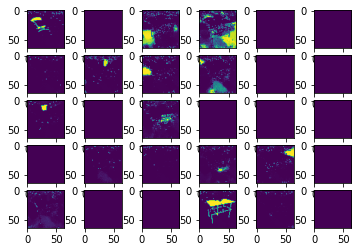

In [9]:
n = predict_masks.shape[-1]
print(predict_masks.shape)
k = 5
m = n // k
for i in range(n):
    plt.subplot(k, n//k, i+1)
    plt.imshow(predict_masks[0,:,:,i])
plt.show()

In [10]:
model.grouper.num_long_range = 0
percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"].clamp(-20,20.) 
indices = percept_outputs["indices"]



predict_masks, _ ,alive, prop_maps = model.extract_segments(obj_affinity, indices)
predict_masks = torch.einsum("bwhn,bnd->bwhn", predict_masks, alive)

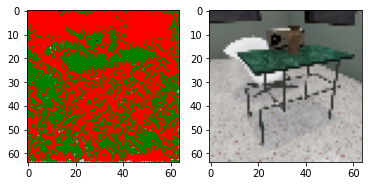

In [11]:
import numpy as np
import math
num_edges = 100

def visualize_affinities(indices, affinity, im = None, num_edges = 10):
    
    _, B, N, K = indices.shape
    W = int(math.sqrt(N))
    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    indices = indices.reshape([3, B, N * K])
    #u_mask = torch.gather(mask, dim = 1, index = filter_u)
    #v_mask = torch.gather(mask, dim = 1, index = filter_v)
    #edge_mask = torch.min(u_mask , v_mask)
    rand_idx = np.random.randint(0,N * K, [num_edges])
    rand_idx = torch.tensor(rand_idx).int()
    aff = affinity.reshape(B, N * K)

    if im is None: im = torch.zeros([B,3, N])
    plt.subplot(121)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))
    for idx in rand_idx:
        u_idx = indices[1,0,idx]
        v_idx = indices[2,0,idx]
        ux, uy = u_idx // W, u_idx % W
        vx, vy = v_idx // W, v_idx % W
        color = "green" if aff[0,idx] > 0.0 else "red"
        plt.plot([uy,vy],[ux,vx], c = color)
    plt.subplot(122)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))

im = sample["img"].reshape([B, 3, W * H])

visualize_affinities(indices, obj_affinity, im, 10000)


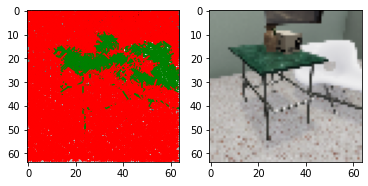

In [12]:
visualize_affinities(indices, obj_affinity, im, 10000)


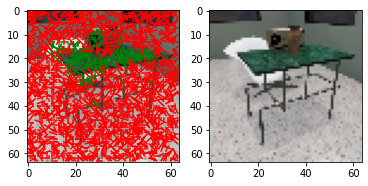

In [14]:
visualize_affinities(indices, obj_affinity, im, 2000)